# General Imports

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline

In [3]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from PIL import Image
from icecream import ic

In [4]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision import transforms as transform_lib
from pytorch_lightning.callbacks import TQDMProgressBar
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
from datasets import GtsrbModule

In [6]:
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.datamodules import STL10DataModule

In [7]:
from models import ResnetModule

In [8]:
from dropblock import DropBlock2D, LinearScheduler

In [9]:
from ls_ood_detect_cea.uncertainty_estimation import Hook
from ls_ood_detect_cea.uncertainty_estimation import deeplabv3p_get_ls_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_latent_represent_mcd_samples
from ls_ood_detect_cea.uncertainty_estimation import get_dl_h_z
from ls_ood_detect_cea.ood_detection_dataset import build_ood_detection_ds
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.detectors import KDEClassifier, DetectorKDE
from ls_ood_detect_cea.score import get_hz_scores
from ls_ood_detect_cea.metrics import get_hz_detector_results
from ls_ood_detect_cea.metrics import get_ood_detector_results
from ls_ood_detect_cea.metrics import plot_roc_ood_detector
from ls_ood_detect_cea.metrics import plot_auprc_ood_detector
from ls_ood_detect_cea.dimensionality_reduction import plot_samples_pacmap
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_ds_split
from ls_ood_detect_cea.dimensionality_reduction import apply_pca_transform

# Load Entropy Values

In [11]:
gtsrb_rn18_a2_h_z_gtsrb_normal_train_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_a2_h_z_gtsrb_normal_train_samples_np.npy')

gtsrb_rn18_a2_h_z_gtsrb_normal_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_a2_h_z_gtsrb_normal_valid_samples_np.npy')
gtsrb_rn18_a2_h_z_gtsrb_normal_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_a2_h_z_gtsrb_normal_test_samples_np.npy')

# gtsrb_rn18_a2_h_z_gtsrb_anomal_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_a2_h_z_gtsrb_anomal_valid_samples_np.npy')
# gtsrb_rn18_a2_h_z_gtsrb_anomal_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_a2_h_z_gtsrb_anomal_test_samples_np.npy')

gtsrb_rn18_a2_h_z_cifar10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_a2_h_z_cifar10_valid_samples_np.npy')
gtsrb_rn18_a2_h_z_cifar10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_a2_h_z_cifar10_test_samples_np.npy')

gtsrb_rn18_a2_h_z_stl10_valid_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_a2_h_z_stl10_valid_samples_np.npy')
gtsrb_rn18_a2_h_z_stl10_test_samples_np = np.load('/media/farnez/Data/EXPERIMENTS/CoRL-2023/gtsrb-classification/resnet18/embeddings/entropy/gtsrb_rn18_a2_h_z_stl10_test_samples_np.npy')

In [12]:
ic(gtsrb_rn18_a2_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_a2_h_z_gtsrb_normal_train_samples_np.shape: (7120, 128)
ic| gtsrb_rn18_a2_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_a2_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_a2_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_a2_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_a2_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_a2_h_z_stl10_test_samples_np.shape: (8000, 128)


# Entropy 2D Projection

(6609, 128)
(6609, 1)
(6609, 2)


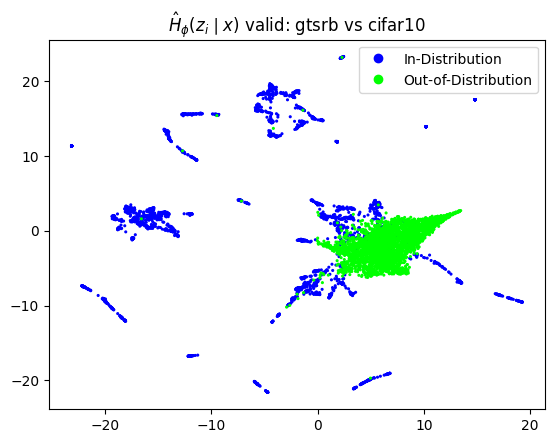

In [32]:
plot_samples_pacmap(gtsrb_rn18_a2_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_a2_h_z_cifar10_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs cifar10")

(4273, 128)
(4273, 1)
(4273, 2)


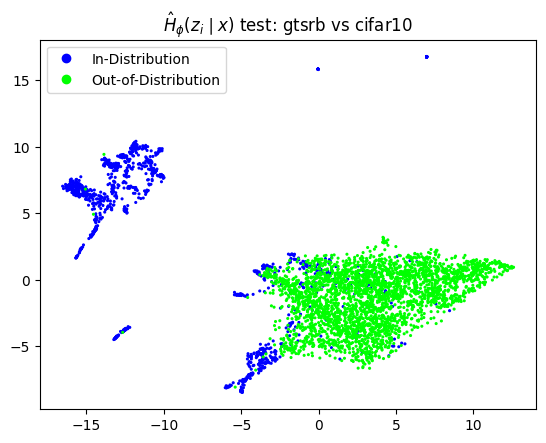

In [35]:
plot_samples_pacmap(gtsrb_rn18_a2_h_z_gtsrb_normal_test_samples_np,
                    gtsrb_rn18_a2_h_z_cifar10_test_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs cifar10")

(6609, 128)
(6609, 1)
(6609, 2)


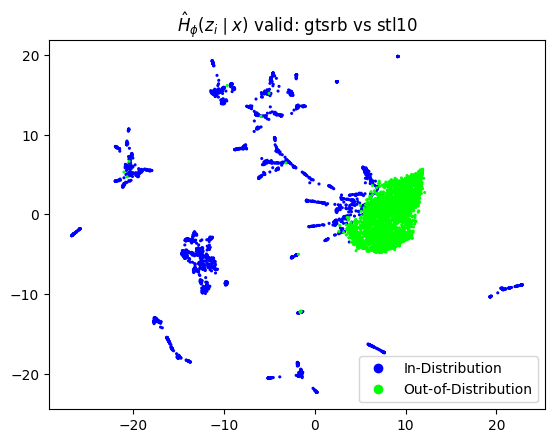

In [21]:
plot_samples_pacmap(gtsrb_rn18_a2_h_z_gtsrb_normal_valid_samples_np,
                    gtsrb_rn18_a2_h_z_stl10_valid_samples_np,
                    neighbors=10,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ valid: gtsrb vs stl10")

(9273, 128)
(9273, 1)
(9273, 2)


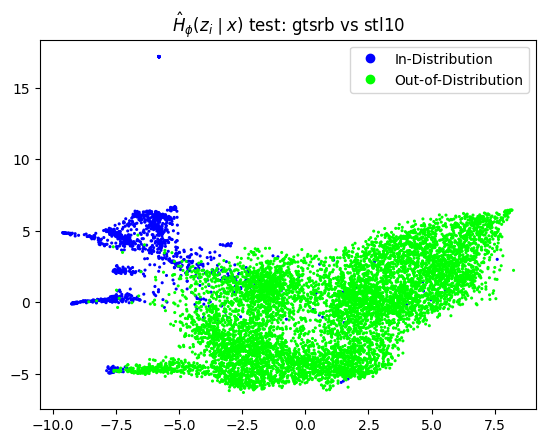

In [37]:
plot_samples_pacmap(gtsrb_rn18_a2_h_z_gtsrb_normal_test_samples_np,
                    gtsrb_rn18_a2_h_z_stl10_test_samples_np,
                    neighbors=16,
                    title="$\hat{H}_{\phi}(z_i \mid x)$ test: gtsrb vs stl10")

# Raw Dataset - Train Data Reference

In [13]:
ic(gtsrb_rn18_a2_h_z_gtsrb_normal_train_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_gtsrb_normal_valid_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_gtsrb_normal_test_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_cifar10_valid_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_cifar10_test_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_stl10_valid_samples_np.shape);
ic(gtsrb_rn18_a2_h_z_stl10_test_samples_np.shape);

ic| gtsrb_rn18_a2_h_z_gtsrb_normal_train_samples_np.shape: (7120, 128)
ic| gtsrb_rn18_a2_h_z_gtsrb_normal_valid_samples_np.shape: (3609, 128)
ic| gtsrb_rn18_a2_h_z_gtsrb_normal_test_samples_np.shape: (1273, 128)
ic| gtsrb_rn18_a2_h_z_cifar10_valid_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_a2_h_z_cifar10_test_samples_np.shape: (10000, 128)
ic| gtsrb_rn18_a2_h_z_stl10_valid_samples_np.shape: (3000, 128)
ic| gtsrb_rn18_a2_h_z_stl10_test_samples_np.shape: (8000, 128)


In [14]:
gtsrb_h_z = np.concatenate((gtsrb_rn18_a2_h_z_gtsrb_normal_valid_samples_np, gtsrb_rn18_a2_h_z_gtsrb_normal_test_samples_np))
cifar10_h_z = np.concatenate((gtsrb_rn18_a2_h_z_cifar10_valid_samples_np, gtsrb_rn18_a2_h_z_cifar10_test_samples_np))
stl10_h_z = np.concatenate((gtsrb_rn18_a2_h_z_stl10_valid_samples_np, gtsrb_rn18_a2_h_z_stl10_test_samples_np))

## Build Detector

In [15]:
gtsrb_ds_shift_detector = DetectorKDE(train_embeddings=gtsrb_rn18_a2_h_z_gtsrb_normal_train_samples_np)

## Get Scores

In [16]:
scores_gtsrb = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_h_z)

scores_cifar10 = get_hz_scores(gtsrb_ds_shift_detector, cifar10_h_z)

scores_stl10 = get_hz_scores(gtsrb_ds_shift_detector, stl10_h_z)

In [17]:
scores_cifar10_val = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_rn18_a2_h_z_cifar10_valid_samples_np)

scores_stl10_val = get_hz_scores(gtsrb_ds_shift_detector, gtsrb_rn18_a2_h_z_stl10_valid_samples_np)


## Get Results

In [18]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_stl10.shape);

results_stl10 = get_hz_detector_results(detect_exp_name="gtsrb vs. stl10",
                                        ind_samples_scores=scores_gtsrb,
                                        ood_samples_scores=scores_stl10)

Test InD shape (4882,)
Test OoD shape (11000,)
AUROC: 0.9813
FPR95: 0.0990
AUPR: 0.9713


gtsrb vs. stl10


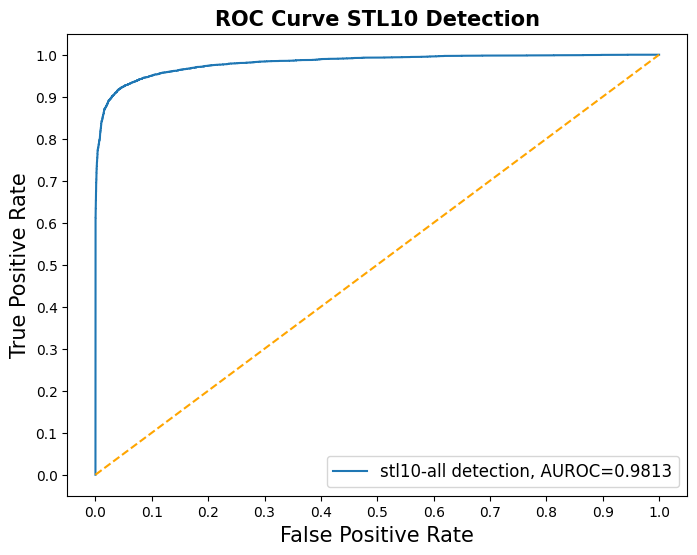

In [19]:
plot_roc_ood_detector(results_table=results_stl10,
                      legend_title="stl10-all detection",
                      plot_title="ROC Curve STL10 Detection")

In [29]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_cifar10.shape);

results_cifar10 = get_hz_detector_results(detect_exp_name="gtsrb vs. cifar10",
                                        ind_samples_scores=scores_gtsrb,
                                        ood_samples_scores=scores_cifar10)

Test InD shape (4882,)
Test OoD shape (20000,)
AUROC: 0.9605
FPR95: 0.2482
AUPR: 0.9128


gtsrb vs. cifar10


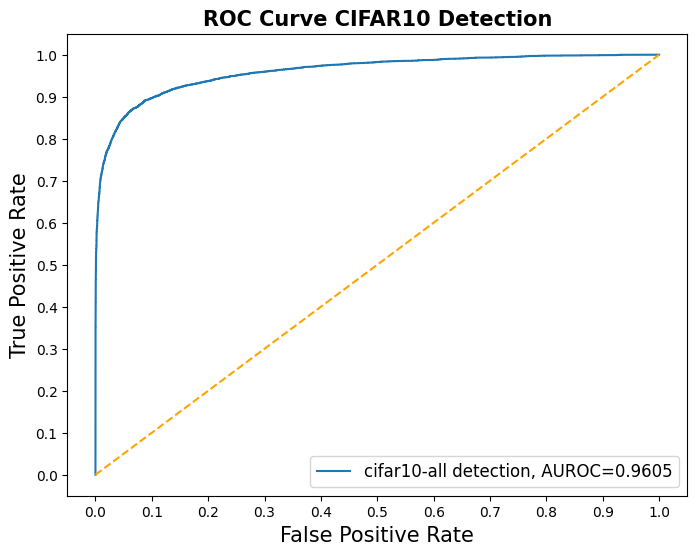

In [30]:
plot_roc_ood_detector(results_table=results_cifar10,
                      legend_title="cifar10-all detection",
                      plot_title="ROC Curve CIFAR10 Detection")

In [31]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_cifar10_val.shape);

results_cifar10_val = get_hz_detector_results(detect_exp_name="gtsrb vs. cifar10-val",
                                              ind_samples_scores=scores_gtsrb,
                                              ood_samples_scores=scores_cifar10_val)

Test InD shape (4882,)
Test OoD shape (10000,)
AUROC: 0.9605
FPR95: 0.2476
AUPR: 0.9442


In [32]:
print("Test InD shape", scores_gtsrb.shape);
print("Test OoD shape", scores_stl10_val.shape);

results_stl10_val = get_hz_detector_results(detect_exp_name="gtsrb vs. stl10-val",
                                            ind_samples_scores=scores_gtsrb,
                                            ood_samples_scores=scores_stl10_val)

Test InD shape (4882,)
Test OoD shape (3000,)
AUROC: 0.9806
FPR95: 0.1070
AUPR: 0.9893


## Plot Score Values

In [36]:
df_scores_gtsrb = pd.DataFrame(scores_gtsrb, columns=["Entropy score"])
df_scores_stl10 = pd.DataFrame(scores_stl10[3500:10500], columns=["Entropy score"])
df_scores_cifar10 = pd.DataFrame(scores_cifar10[7500:13500], columns=["Entropy score"])

df_scores_stl10_val = pd.DataFrame(scores_stl10_val, columns=["Entropy score"])
df_scores_cifar10_val = pd.DataFrame(scores_cifar10_val, columns=["Entropy score"])

df_scores_gtsrb.insert(0, "Dataset", "")
df_scores_gtsrb.loc[:, "Dataset"] = "gtsrb"

df_scores_stl10.insert(0, "Dataset", "")
df_scores_stl10.loc[:, "Dataset"] = "stl10"

df_scores_cifar10.insert(0, "Dataset", "")
df_scores_cifar10.loc[:, "Dataset"] = "cifar10"

df_scores_stl10_val.insert(0, "Dataset", "")
df_scores_stl10_val.loc[:, "Dataset"] = "stl10-val"

df_scores_cifar10_val.insert(0, "Dataset", "")
df_scores_cifar10_val.loc[:, "Dataset"] = "cifar10-val"

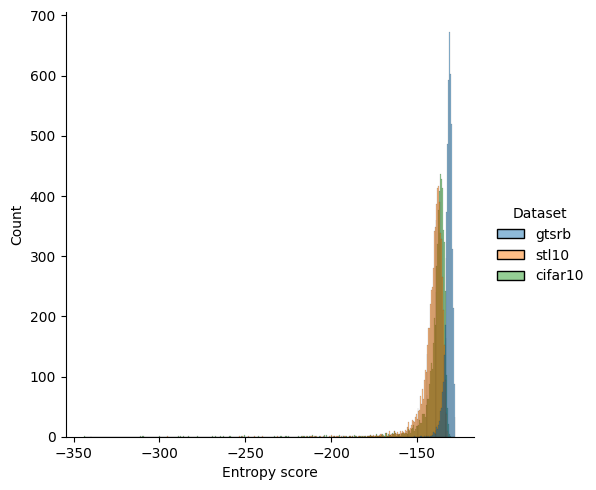

In [37]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

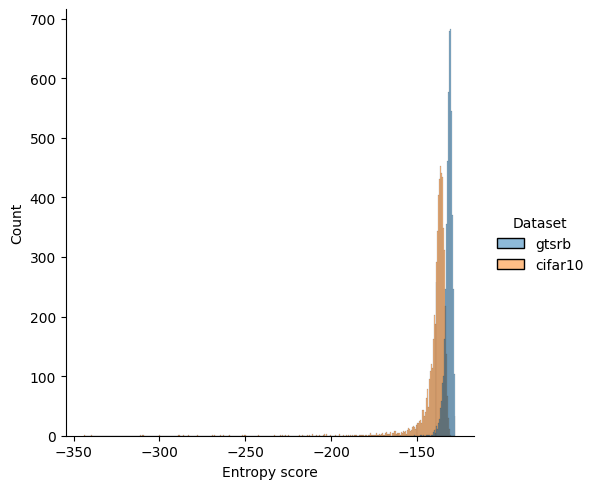

In [38]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_cifar10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

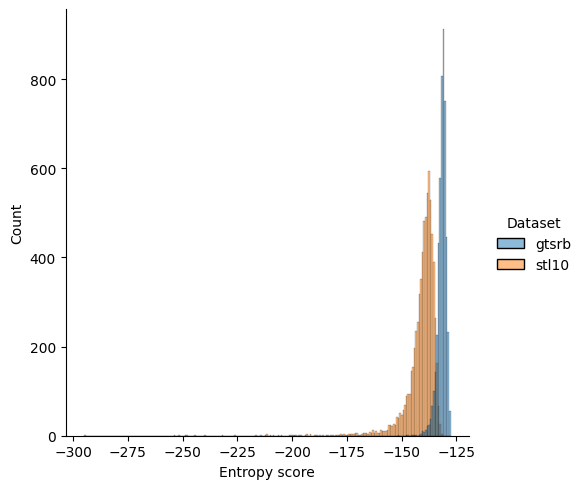

In [39]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

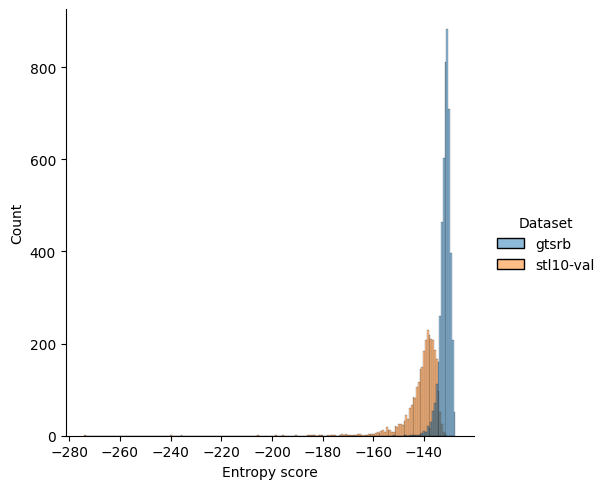

In [40]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_stl10_val]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()

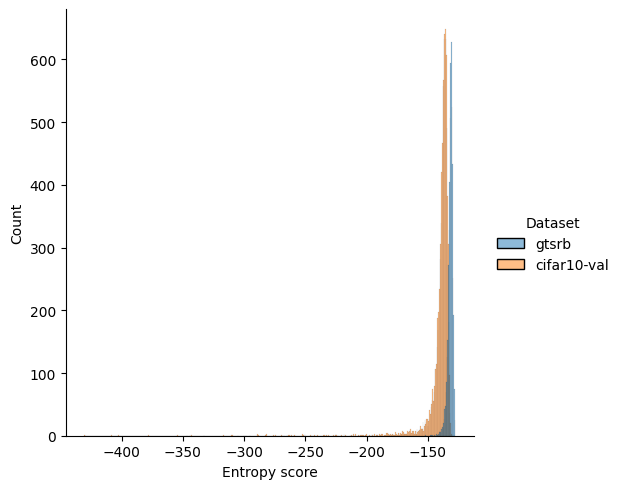

In [41]:
df_h_z_valid_scores = pd.concat([df_scores_gtsrb,
                                 df_scores_cifar10_val]).reset_index(drop=True)

sns.displot(df_h_z_valid_scores, x="Entropy score", hue="Dataset", kind="hist", fill=True)
plt.show()